# Single Cell Classification
> ML/AI Exam Project

- toc: true
- badges: true
- comments: true
- categories: [jupyter, exercise]
- image: images/chart-preview.png

Group Members:
- Johannes Ehlers Nyholm Thomsen
- Kaare Veggerby Sandbøl
- Kasper Malmsiø Hoffmann
- Mike Holst Meldgaard

In [1]:
import pandas as pd
import numpy as np

import os
import io
import base64
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from fastai.vision.all import *
import torch.nn.functional as nnf

import torch
torch.cuda.empty_cache()

from fastai.callback.all import *

In [2]:
from scclib.util.image import create_samples, assemble_rgb_image, get_rgb_pieces_tensors, HPAImage

## Collect data:
Vores data, som er udleveret fra Kaggle, skal vi have samlet i det udleverede data til en kanal.
Et billede er udleveret som 4 greyscaled billeder,
hvor hvert greyscaled billede repræsenterer rød, grøn, blå og gul farve af det samlede billede.

I denne konkurrences forum har folk konkluderet, at den gule del af billedet har ingen indflydelse på modellernes præcision, hvorfor vi har valgt at sortere den fra.

Vi skal derfor have samlet de 3 RBG billeder til et samlet billede.
Til at gøre dette har vi lavet et hjælpe bibliotek, da det bare er en masse python kode.
Koden tager de 3 billeder, putter deres data i den respektive farve kanal for et samlet billede og resizer til en ønsket størrelse.
Vi resizer allerede her, da vi så kan gøre det på GPU i stedet for CPU'en.

In [3]:
cuda0 = torch.device('cuda:0')

In [4]:
data_path = Path('Z:\cloud\data\hpa-single-cell-image-classification')
path = Path('../data')

In [5]:
df = pd.read_csv(data_path/'train.csv')

In [6]:
df.head()

,ID,Label
0,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0,8|5|0
1,5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0,14|0
2,60b57878-bb99-11e8-b2b9-ac1f6b6435d0,6|1
3,5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0,16|10
4,5b931256-bb99-11e8-b2b9-ac1f6b6435d0,14|0


In [7]:
labels = [str(i) for i in range(19)]
for x in labels:
    df[x] = df['Label'].apply(lambda r: int(x in r.split('|')))

df.head()

,ID,Label,0,1,2,3,4,5,6,7,...,9,10,11,12,13,14,15,16,17,18
0,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0,8|5|0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0,14|0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,60b57878-bb99-11e8-b2b9-ac1f6b6435d0,6|1,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0,16|10,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
4,5b931256-bb99-11e8-b2b9-ac1f6b6435d0,14|0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [8]:
dfs_0 = df[df['Label'] == '0'].sample(n=300, random_state=42).reset_index(drop=True)
dfs_1 = df[df['1'] == 1].sample(n=400, random_state=42).reset_index(drop=True)
dfs_1u = df[df['Label'] == '1'].sample(n=221, random_state=42).reset_index(drop=True)
dfs_2 = df[df['Label'] == '2'].sample(n=500, random_state=42).reset_index(drop=True)
dfs_3 = df[df['Label'] == '3'].sample(n=500, random_state=42).reset_index(drop=True)
dfs_4 = df[df['Label'] == '4'].sample(n=500, random_state=42).reset_index(drop=True)
dfs_5 = df[df['Label'] == '5'].sample(n=500, random_state=42).reset_index(drop=True)
dfs_6 = df[df['6'] == 1].sample(n=500, random_state=42).reset_index(drop=True)
dfs_7 = df[df['Label'] == '7'].sample(n=500, random_state=42).reset_index(drop=True)
dfs_8 = df[df['Label'] == '8'].sample(n=500, random_state=42).reset_index(drop=True)
dfs_9 = df[df['9'] == 1].sample(n=400, random_state=42).reset_index(drop=True)
dfs_9u = df[df['Label'] == '9'].sample(n=200, random_state=42).reset_index(drop=True)
dfs_10 = df[df['10'] == 1].sample(n=400, random_state=42).reset_index(drop=True)
dfs_10u = df[df['Label'] == '10'].sample(n=200, random_state=42).reset_index(drop=True)
dfs_11 = df[df['11'] == 1].reset_index(drop=True)
dfs_12 = df[df['Label'] == '12'].sample(n=500, random_state=42).reset_index(drop=True)
dfs_13 = df[df['Label'] == '13'].sample(n=400, random_state=42).reset_index(drop=True)
dfs_14 = df[df['Label'] == '14'].sample(n=500, random_state=42).reset_index(drop=True)
dfs_15 = df[df['15'] == 1].reset_index(drop=True)
dfs_16 = df[df['Label'] == '16'].sample(n=350, random_state=42).reset_index(drop=True)
dfs_17 = df[df['17'] == 1].sample(n=500, random_state=42).reset_index(drop=True)
dfs_18 = df[df['18'] == 1].reset_index(drop=True)
dfs_ = [dfs_0, dfs_1, dfs_1u, dfs_2, dfs_3, dfs_4, dfs_5, dfs_6, dfs_7, dfs_8, dfs_9, dfs_9u, dfs_10, dfs_10u,
        dfs_11, dfs_12, dfs_13, dfs_14, dfs_15, dfs_16, dfs_17, dfs_18]

In [9]:
dfs = pd.concat(dfs_, ignore_index=True)
dfs.drop_duplicates(inplace=True, ignore_index=True)

In [10]:
data_path = Path('../data')

image_path = Path('Z:/cloud/data/hpa-single-cell-image-classification/train')
image_destination = data_path/'train'

if not image_destination.exists():
    os.makedirs(image_destination)

In [11]:
example_image = image_path.ls()[0].name
image_id, image_ext = example_image.split('.')

image_id = image_id.split('_')[0]

## Data Preparation:
Billederne bliver udleveret i en kvalitet af 1080p og op efter.
Vi har valgt at resize dem til 512 gange 512 for at bevare nok billede kvalitet men også undgå at løbe tør for hukkomelse på computeren.

Efter vi har fundet dataen skal vi have loaded dem ind i en dataloader.
Samtidig med at vi gør det cropper vi også billederne ned til 256 gange 256 opløsning,
og da vi bruger batch_tfms sker der en tilfældig crop og augmentering.
Der sker dog kun resizing på valideringssettet.

Vi har altså været nød til selv manuelt at implementere den fremgangsmåde,
som fastai kalder presizing, da vores udleverede billeder er i så høj kvalitet.
Vi interpolerer dog 2 gange i stedet for kun én gang, som hvis vi brugte fastai presizing,
hvilket resulterer i en ringere billedkvalitet, men vi vinder performance.

C:\Users\Marianne\source\repos\SingleCellClassification\scclib\util\image.py:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  return torch.from_numpy(arr)


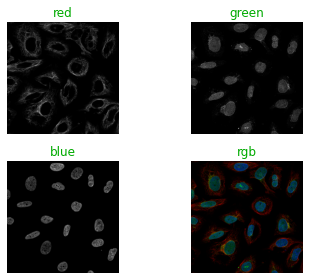

In [12]:
new_img = HPAImage(id=image_id,
                   ext=image_ext,
                   path=image_path,
                   device="cuda:0",
                   size=512)

new_img.plot_all()

In [13]:
create_samples(512, dfs, image_path, image_destination, csv_path=data_path/'cells_sample.csv', device="cuda:0")

100%|██████████| 7960/7960 [00:02<00:00, 3480.55it/s]


In [14]:
models_path = Path('../models')
path = Path('../data')

In [15]:
cell_df = pd.read_csv(path/'cells_sample.csv')
cell_df.head()

,image_id,image_labels
0,0e63afe6-bbca-11e8-b2bc-ac1f6b6435d0,0
1,6166673c-bbad-11e8-b2ba-ac1f6b6435d0,0
2,2533bcc2-bba5-11e8-b2ba-ac1f6b6435d0,0
3,280f88c2-bba5-11e8-b2ba-ac1f6b6435d0,0
4,13669cc6-bbaa-11e8-b2ba-ac1f6b6435d0,0


In [16]:
def get_x(r): return path/'train'/f"{r['image_id']}.png"
def get_y(r): return r['image_labels'].split('|')

In [17]:
def get_dls(bs: int, size: int):
    return DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                     splitter=RandomSplitter(seed=42),
                     get_x=get_x,
                     get_y=get_y,
                     batch_tfms=aug_transforms(size=size, min_scale=0.75))\
        .dataloaders(cell_df, bs=bs, num_workers=0)

In [18]:
batch_size = 64
image_size = 256

dls = get_dls(batch_size, image_size)

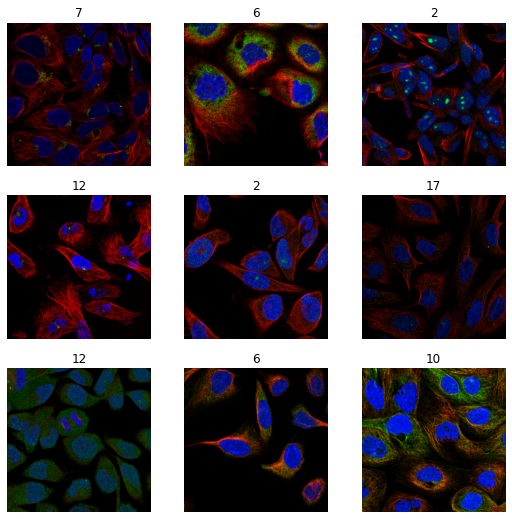

In [19]:
dls.show_batch()

## Choose Model:
Vi har valgt at bruge et residualt netværk, som er trænet på ImageNet.
I vores model er det kun et netværk med 18 lag, så vi ikke skal vente hundrede år mellem hver træning,
når vi eksperimenterer med modellen.
Derudover så vi ikke en markant højere præcision, da vi trænede med modellen med 50 lag.
Det kan også ses, at vi bruger fp16 for at spare regnekraft mens vi træner.

In [20]:
learn = cnn_learner(dls, resnet18, metrics=partial(accuracy_multi, thresh=0.2)).to_fp16()


## Evaluation:
Til vores models metric bruger vi standard præcision for multicategory, hvilket er accuracy_multi.
Vi vil dog gerne have en threshhold på 0.2, derfor er vi nød til at give mertics en partial,
hvilket betyder at der laves en ny version af accuracy_multi, hvor threshold er den værdi vi sender med i partial.

## Tuning:
Da vi har valgt at bruge en på-forhånd trænet model, ResNet, er vi nød til at finjustere den til vores problem.
Dette gøres ved at kalde fine_tune på vores learner.
fine_tune smider det sidste linære lag i modellen væk og skifter det ud med et nyt linært lag.
Dernæst fryser modellen vægtene i alle de gamle lag, og træner nu det nye linære lag i en epoche.
Derefter tøes de frosne lag op og modellen trænes nu sammen i det ønskede antal gange - her er det 5.

På denne måde undgår vi at smide alt den træning modellen har fra ImageNet væk,
og modellen bliver stadig optimeret til lige vores problemstilling.

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.033113110810518265)

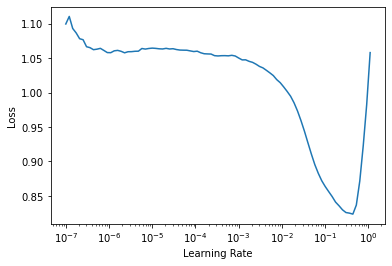

In [21]:
learn.lr_find()

In [22]:
with learn.no_bar():
    learn.fine_tune(10, base_lr=0.03)

[0, 0.34980544447898865, 0.21575936675071716, 0.897976815700531, '01:12']
[0, 0.19443851709365845, 0.17364072799682617, 0.9226064085960388, '01:13']
[1, 0.17741426825523376, 0.23870453238487244, 0.890835702419281, '01:13']
[2, 0.1630779206752777, 0.18634462356567383, 0.9153332710266113, '01:16']
[3, 0.1506965458393097, 0.17100191116333008, 0.9302763342857361, '01:15']
[4, 0.138868510723114, 0.16251589357852936, 0.9270033240318298, '01:12']
[5, 0.12858404219150543, 0.1374361515045166, 0.9359297156333923, '01:12']
[6, 0.11740823090076447, 0.12153063714504242, 0.9489883184432983, '01:12']
[7, 0.10452622920274734, 0.12300284951925278, 0.9457483887672424, '01:13']
[8, 0.09402365237474442, 0.11247400939464569, 0.9501455426216125, '01:09']
[9, 0.08716251701116562, 0.11231212317943573, 0.9507405757904053, '01:10']


In [23]:
class Hook:
    def hook_func(self, model, input, output):
        self.stored = output.detach().clone()

In [24]:
hook_output = Hook()
hook = learn.model[0].register_forward_hook(hook_output.hook_func)


In [25]:
x = dls.one_batch()[0][0].unsqueeze(0)

In [26]:
print(x.shape)
print(x)

torch.Size([1, 3, 256, 256])
TensorImage([[[[-2.0231, -2.0357, -2.0299,  ..., -1.6746, -1.4395, -1.5836],
          [-2.0286, -2.0056, -2.0632,  ..., -1.7627, -1.6788, -1.6909],
          [-2.0218, -2.0498, -2.0858,  ..., -1.7766, -1.6992, -1.6864],
          ...,
          [-0.7180, -1.8194, -1.9184,  ..., -1.5146, -0.9398, -0.9181],
          [-1.6267, -1.8597, -1.9624,  ..., -1.5632, -1.5681, -1.2201],
          [-1.8928, -1.9339, -1.9746,  ..., -1.0895, -0.1448, -0.5516]],

         [[-2.0302, -1.9965, -2.0278,  ..., -1.9795, -2.0335, -2.0310],
          [-2.0306, -2.0083, -2.0152,  ..., -1.7657, -2.0251, -2.0326],
          [-2.0229, -2.0334, -2.0357,  ..., -1.9133, -2.0004, -1.9826],
          ...,
          [-1.9782, -1.9471, -2.0050,  ..., -1.9584, -1.8945, -1.9435],
          [-1.9265, -1.9703, -1.9974,  ..., -1.8735, -1.7904, -1.7379],
          [-1.9151, -1.9776, -2.0173,  ..., -1.7882, -1.5698, -1.7833]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.804

In [27]:
with torch.no_grad(): output = learn.model.eval()(x)

In [28]:
act = hook_output.stored[0]

In [29]:
F.softmax(output, dim=-1)

tensor([[9.3069e-03, 9.8083e-01, 3.0847e-05, 1.2865e-05, 1.1578e-03, 4.2077e-04,
         1.6482e-05, 8.6766e-05, 3.8656e-03, 7.4111e-05, 6.5331e-05, 5.8279e-04,
         4.6459e-05, 1.0263e-04, 2.0953e-03, 1.3299e-04, 1.7882e-04, 2.1191e-04,
         7.8174e-04]], device='cuda:0')

In [30]:
dls.vocab

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '2', '3', '4', '5', '6', '7', '8', '9']

In [31]:
cam_map = torch.einsum('ck,kij->cij', learn.model[1][-1].weight, act)
cam_map.shape

torch.Size([19, 8, 8])

In [32]:
cam_map[1]

tensor([[-11.7976,  -8.8484,  -9.0233,  -9.5797, -13.6296, -15.6943, -13.6190,
         -13.1508],
        [ -7.6053,  -5.0152,  -7.8845,  -9.5468, -10.7061, -13.3279,  -9.2101,
         -10.0630],
        [ -5.5384,  -3.8083,  -7.0739,  -9.1266,  -8.7326,  -7.5732,  -4.4432,
          -9.2882],
        [ -5.9409,  -3.0918,  -6.9509,  -7.3649,  -8.8905,  -9.3576,  -6.9014,
         -12.0372],
        [ -6.1369,  -2.9236,  -4.8785,  -7.4147,  -7.4539,  -9.9532, -10.8462,
         -16.2405],
        [-10.1607,  -7.5774,  -7.2242, -11.0472,  -8.8943,  -9.8135, -13.6099,
         -21.2422],
        [-14.1123, -10.2740, -11.2755, -11.2595, -11.4919,  -9.7790, -13.1679,
         -17.1019],
        [-21.0718, -15.0101, -14.2335, -12.5560, -12.0332, -15.0552, -19.4397,
         -19.5940]], device='cuda:0', grad_fn=<SelectBackward>)

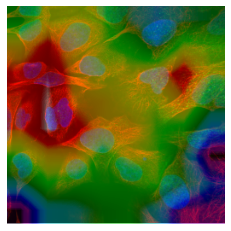

In [33]:
x_dec = TensorImage(dls.train.decode((x,))[0][0])
_,ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map[1].detach().cpu(), alpha=0.5, extent=(0,256,256,0), interpolation='bilinear', cmap='nipy_spectral')

In [34]:
time_now  = datetime.now().strftime(format='%y%m%d-%H%M%S')
model_name = f'{time_now}_resnet18_e10_lr-003.pkl'
learn.export(fname=models_path/model_name)

## Prediction:
Vi har ikke kunnet få Kaggle til at give os en score på vores model,
da de vil vores predictions i en meget speciel og træls opsætning.

In [35]:
torch.cuda.empty_cache()

In [36]:
path = Path('Z:/cloud/data/hpa-single-cell-image-classification/test')

In [37]:
images = get_image_files(path)
images

(#2236) [Path('Z:/cloud/data/hpa-single-cell-image-classification/test/0040581b-f1f2-4fbe-b043-b6bfea5404bb_blue.png'),Path('Z:/cloud/data/hpa-single-cell-image-classification/test/0040581b-f1f2-4fbe-b043-b6bfea5404bb_green.png'),Path('Z:/cloud/data/hpa-single-cell-image-classification/test/0040581b-f1f2-4fbe-b043-b6bfea5404bb_red.png'),Path('Z:/cloud/data/hpa-single-cell-image-classification/test/0040581b-f1f2-4fbe-b043-b6bfea5404bb_yellow.png'),Path('Z:/cloud/data/hpa-single-cell-image-classification/test/004a270d-34a2-4d60-bbe4-365fca868193_blue.png'),Path('Z:/cloud/data/hpa-single-cell-image-classification/test/004a270d-34a2-4d60-bbe4-365fca868193_green.png'),Path('Z:/cloud/data/hpa-single-cell-image-classification/test/004a270d-34a2-4d60-bbe4-365fca868193_red.png'),Path('Z:/cloud/data/hpa-single-cell-image-classification/test/004a270d-34a2-4d60-bbe4-365fca868193_yellow.png'),Path('Z:/cloud/data/hpa-single-cell-image-classification/test/00537262-883c-4b37-a3a1-a4931b6faea5_blue.png

In [38]:
learn_inf = load_learner(models_path/model_name, cpu=False)

In [39]:
test_dl = learn_inf.dls.test_dl(images)

In [40]:
item = test_dl.one_batch()[0]

with learn_inf.no_bar():
    predictions, _ = learn_inf.predict(item)

RuntimeError: stack expects each tensor to be equal size, but got [3, 2048, 2048] at entry 0 and [3, 3072, 3072] at entry 16